In [6]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

df_washington = pd.read_csv("data/washington.csv", sep = ";")
# df_convention = pd.read_csv("data/convention.csv", sep = ";")
# df_sts = pd.read_csv("data/sts.csv", sep = ";")

def filter(df,amont,aval):
    df = df[df["Libelle noeud amont"]==amont]
    df = df[df["Libelle noeud aval"]==aval]
    return df

def set_date(df):
    df["Date et heure de comptage"] = pd.to_datetime(df_washington["Date et heure de comptage"],format='%Y-%m-%dT%H:%M:%S%z')
    return df


df_washington = filter(df_washington,"Av_Champs_Elysees-Washington","Av_Champs_Elysees-Berri")
df_washington = set_date(df_washington)
df_washington = df_washington.sort_values(by = "Date et heure de comptage")
df_washington = df_washington.interpolate() #remove Nan by interpolation
df_washington = df_washington.reset_index()
# df_sts = filter(df_sts,"Lecourbe-Convention","Convention-Blomet")
# df_convention = filter(df_convention,"Sts_Peres-Voltaire","Sts_Peres-Universite")

df_washington.head()


,index,Identifiant arc,Libelle,Date et heure de comptage,Débit horaire,Taux d'occupation,Etat trafic,Identifiant noeud amont,Libelle noeud amont,Identifiant noeud aval,Libelle noeud aval,Etat arc,Date debut dispo data,Date fin dispo data,geo_point_2d,geo_shape
0,6712,4264,AV_Champs_Elysees,2019-11-01 04:00:00+01:00,746.0,10.98889,Fluide,2294,Av_Champs_Elysees-Washington,2293,Av_Champs_Elysees-Berri,Invalide,2005-01-01,2019-06-01,"48.8715358799,2.30172279246","{""type"": ""LineString"", ""coordinates"": [[2.3009..."
1,6713,4264,AV_Champs_Elysees,2019-11-01 05:00:00+01:00,549.0,7.40722,Fluide,2294,Av_Champs_Elysees-Washington,2293,Av_Champs_Elysees-Berri,Invalide,2005-01-01,2019-06-01,"48.8715358799,2.30172279246","{""type"": ""LineString"", ""coordinates"": [[2.3009..."
2,6714,4264,AV_Champs_Elysees,2019-11-01 06:00:00+01:00,503.0,7.66667,Fluide,2294,Av_Champs_Elysees-Washington,2293,Av_Champs_Elysees-Berri,Invalide,2005-01-01,2019-06-01,"48.8715358799,2.30172279246","{""type"": ""LineString"", ""coordinates"": [[2.3009..."
3,2607,4264,AV_Champs_Elysees,2019-11-01 07:00:00+01:00,500.0,4.75500,Fluide,2294,Av_Champs_Elysees-Washington,2293,Av_Champs_Elysees-Berri,Invalide,2005-01-01,2019-06-01,"48.8715358799,2.30172279246","{""type"": ""LineString"", ""coordinates"": [[2.3009..."
4,2608,4264,AV_Champs_Elysees,2019-11-01 08:00:00+01:00,525.0,5.37389,Fluide,2294,Av_Champs_Elysees-Washington,2293,Av_Champs_Elysees-Berri,Invalide,2005-01-01,2019-06-01,"48.8715358799,2.30172279246","{""type"": ""LineString"", ""coordinates"": [[2.3009..."


In [7]:
#######
#features
#######
df_X = pd.DataFrame({"dt": df_washington["Date et heure de comptage"],"debit" : df_washington["Débit horaire"],"occupation" : df_washington["Taux d'occupation"]})
df_X

,dt,debit,occupation
0,2019-11-01 04:00:00+01:00,746.0,10.98889
1,2019-11-01 05:00:00+01:00,549.0,7.40722
2,2019-11-01 06:00:00+01:00,503.0,7.66667
3,2019-11-01 07:00:00+01:00,500.0,4.75500
4,2019-11-01 08:00:00+01:00,525.0,5.37389
...,...,...,...
9447,2020-11-30 20:00:00+01:00,784.0,9.80056
9448,2020-11-30 21:00:00+01:00,519.0,6.37445
9449,2020-11-30 22:00:00+01:00,326.0,4.76667
9450,2020-11-30 23:00:00+01:00,216.0,2.63333


In [8]:
df_X["hour"]= [d.hour for d in df_X["dt"]]
df_X["weekday"]= [d.weekday() for d in df_X["dt"]]
df_X["month"]= [d.month for d in df_X["dt"]]
df_X["mean_debit_past_week"] = df_X.debit.rolling(24*7).mean().shift(24*5) #mean debit of the week 5 days before
df_X["mean_occupation_past_week"] = df_X.occupation.rolling(24*7).mean().shift(24*5) #mean debit of the week 5 days before

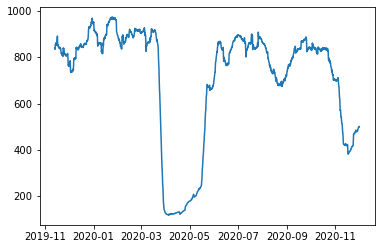

In [9]:
plt.plot(df_X.dt,df_X.mean_debit_past_week)

In [10]:
df_fin=df_X[24*7+24*5:]
X=df_fin[["hour","weekday","mean_occupation_past_week"]]
Y_occupation=df_fin[["occupation"]]
Y_debit=df_fin[["debit"]]

In [17]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score

i_split = int(len(X)*0.8)
# i_split=3200
X_train = X[:i_split].values
y_train = Y_occupation[:i_split].values
X_test = X[i_split:].values
y_test = Y_occupation[i_split:].values

model = RandomForestRegressor(min_samples_leaf=5)
model.fit(X_train,y_train)
pred = model.predict(X_test)


7331


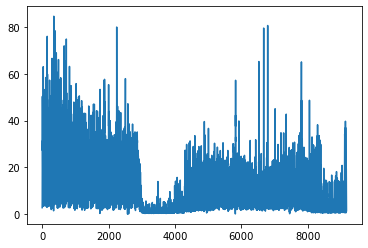

In [18]:
plt.plot(Y_occupation.values)
print(i_split)

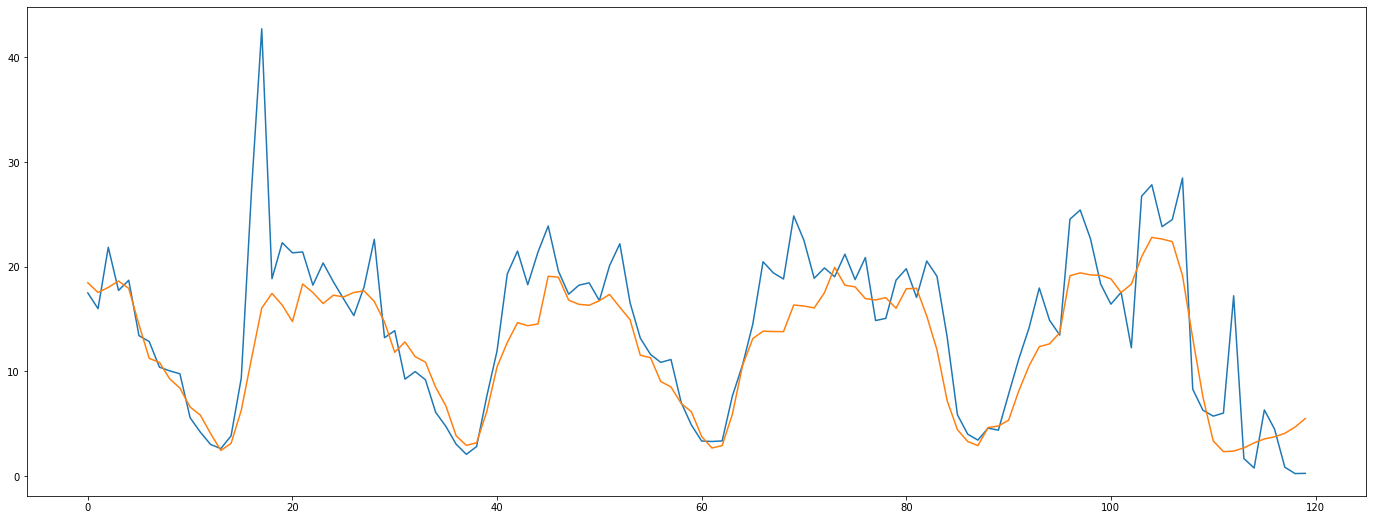

In [19]:
plt.figure(figsize=(24,9))
plt.plot(y_test[:24*5])
plt.plot(pred[:24*5])
plt.show()